<a href="https://colab.research.google.com/github/rocodoco20/AI1week/blob/main/cuda_psy_3week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DistilBERT fine-tuning으로 감정 분석 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 감정 분석 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 500.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This b

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [ ]:
from transformers import AutoTokenizer
from collections import Counter
import torch
# ds = load_dataset("stanfordnlp/imdb")
ds = load_dataset("fancyzhx/ag_news") # Huggingface dataset의 fancyzhx/ag_news를 load합니다.
print("AG News 클래스:", ds['train'].features['label'].names) # AG News 데이터셋 클래스 이름들을 출력합니다.
# 학습 데이터셋에서 레이블 추출
train_labels = [sample['label'] for sample in ds['train']]

# 각 레이블의 개수 세기
label_counts = Counter(train_labels)

# 레이블 개수와 해당 이름 출력
for label_id, count in label_counts.items():
    label_name = ds['train'].features['label'].names[label_id]  # 레이블 ID를 이용하여 레이블 이름 가져오기
    print(f"{label_name}: {count}")  # 레이블 이름과 개수 출력

# Tokenizer 로드
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def collate_fn(batch):
  max_len = 400
  all_texts, all_labels = [], []  # 변수명의 혼동을 피하기 위해서 이름 재정의
  for row in batch:
    all_labels.append(row['label'])
    all_texts.append(row['text'])

  # Get both input_ids and attention_mask
  encoded_inputs = tokenizer(all_texts, padding=True, return_tensors="pt")
  texts = encoded_inputs.input_ids
  attention_masks = encoded_inputs.attention_mask  # Get attention_mask

  labels = torch.LongTensor(all_labels)

  return texts, attention_masks, labels  # Return both

train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)


AG News 클래스: ['World', 'Sports', 'Business', 'Sci/Tech']
Business: 30000
Sci/Tech: 30000
Sports: 30000
World: 30000


## [LOG] 클래스 텍스트 길이 분포

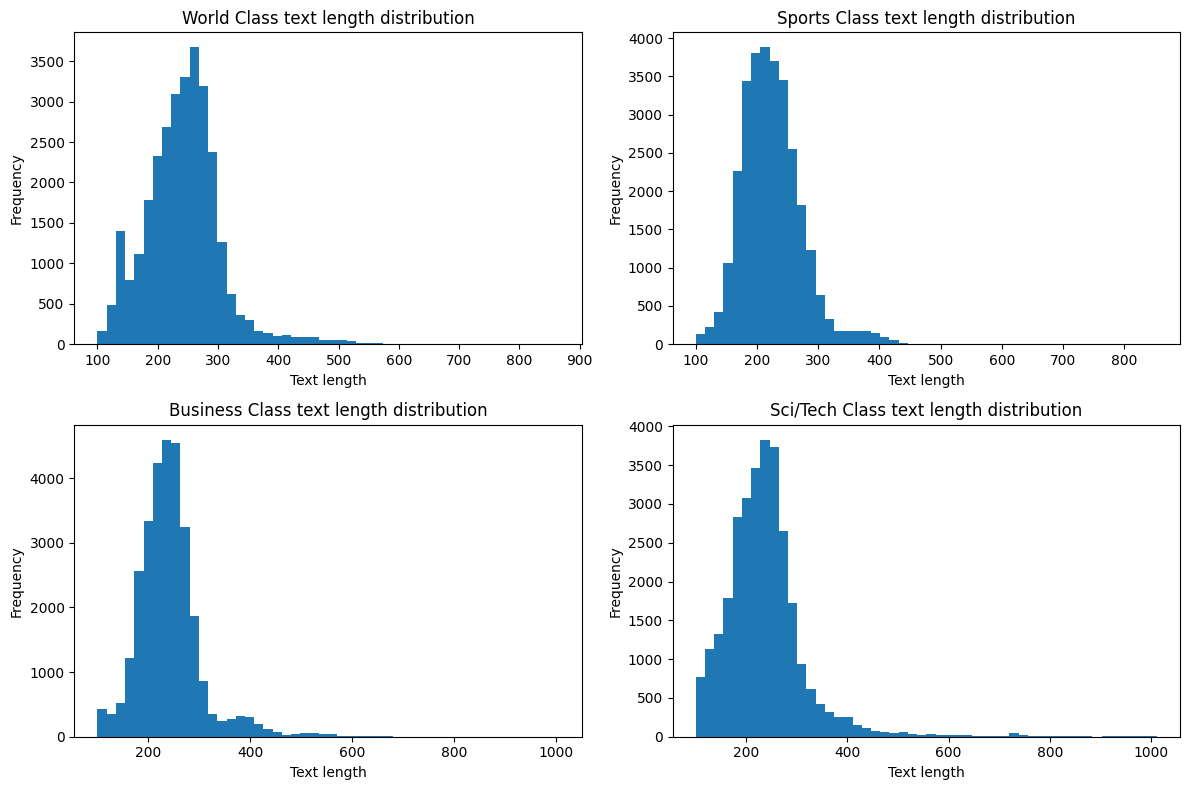

In [ ]:
# 클래스 레이블
class_labels = ds['train'].features['label'].names

# 클래스별 텍스트 길이 저장
class_lengths = {
    0: [],  # World
    1: [],  # Sports
    2: [],  # Business
    3: []   # Sci/Tech
}

# 클래스별로 텍스트 길이 추가
for sample in ds['train']:
    class_lengths[sample['label']].append(len(sample['text']))

# subplot 설정 (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # figsize로 그래프 크기 조절

# 각 클래스별로 바 그래프 생성
for i, label in enumerate(class_labels):
    row = i // 2  # subplot 행 위치 계산
    col = i % 2   # subplot 열 위치 계산
    ax = axes[row, col]  # 현재 subplot 선택

    ax.hist(class_lengths[i], bins=50)  # 히스토그램 생성
    ax.set_xlabel('Text length')  # x축 레이블
    ax.set_ylabel('Frequency')  # y축 레이블
    ax.set_title(f'{label} Class text length distribution')  # 제목

plt.tight_layout()  # subplot 간 간격 조절
plt.show()  # 그래프 출력

## [LOG] 각 클래스별 상위 10개 단어 중 연관된 단어 추출
 - all_top_words 리스트 생성: 모든 클래스에서 상위 100개 단어를 모아 all_top_words 리스트에 저장합니다.
 - common_words 리스트 생성: all_top_words 리스트에서 중복된 단어 10개를 선택하여 common_words 리스트에 저장합니다.
 - 중복된 단어 추출: 각 클래스별 상위 100개 단어 중에서 common_words 리스트에 있는 단어들만 선택하여 top_common_words 리스트에 저장합니다.
 - 그래프 그리기: top_common_words 리스트를 사용하여 그래프를 그립니다.

<ipython-input-46-009fe6420290>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45, ha='right')
<ipython-input-46-009fe6420290>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45, ha='right')
<ipython-input-46-009fe6420290>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45, ha='right')
<ipython-input-46-009fe6420290>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45, ha='right')


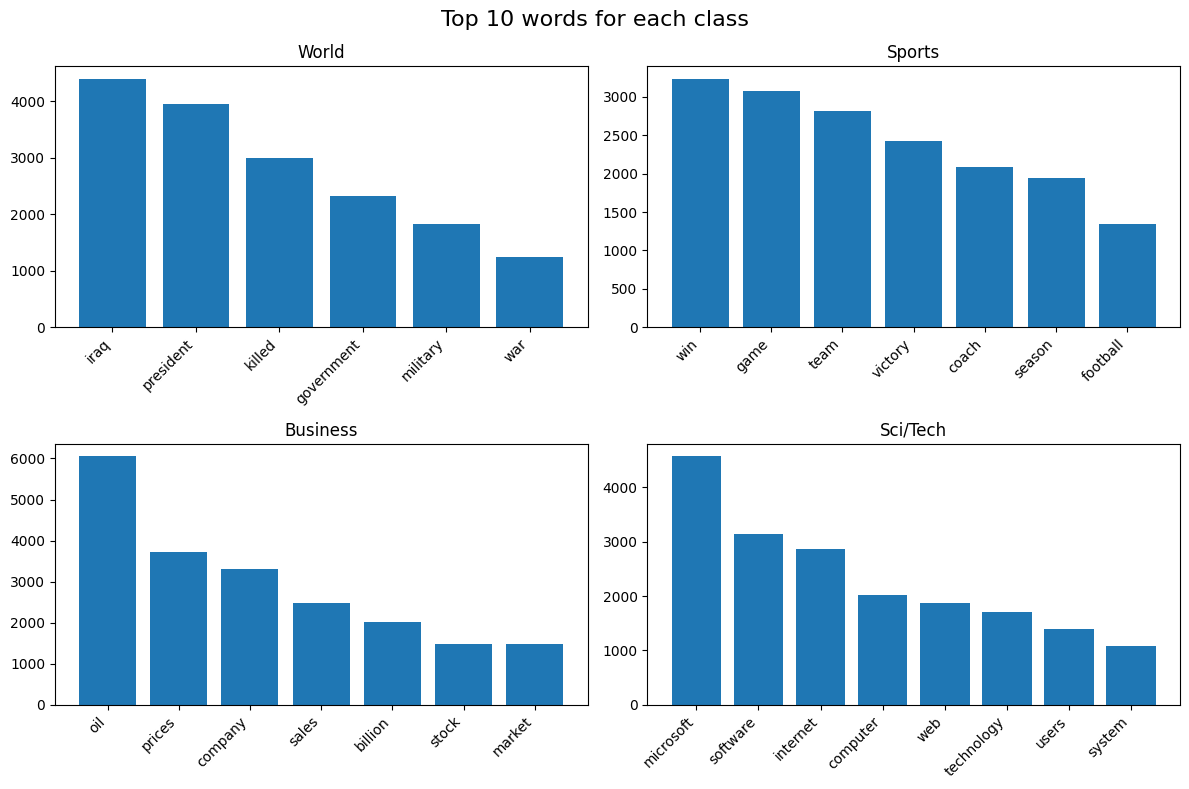

In [ ]:
# 클래스별 단어 빈도수 계산 (소문자로 변환 후 단어 분리)
class_word_counts = {label: Counter() for label in ds['train'].features['label'].names}
for sample in ds['train']:
    label = ds['train'].features['label'].names[sample['label']]
    for word in sample['text'].lower().split():
        class_word_counts[label][word] += 1

# 클래스와 연관된 단어 선택 (예시)
related_words = {
    "World": ["war", "iraq", "nations", "country", "government", "president", "killed", "military", "attack", "china"],
    "Sports": ["game", "team", "win", "player", "season", "victory", "coach", "baseball", "football", "score"],
    "Business": ["company", "market", "stock", "sales", "economy", "industry", "oil", "prices", "financial", "billion"],
    "Sci/Tech": ["technology", "computer", "software", "internet", "science", "research", "users", "microsoft", "system", "web"]
}

# 각 클래스별 상위 10개 단어 중 연관된 단어 추출
top_related_words_per_class = {}
for label, word_counts in class_word_counts.items():
    top_words = word_counts.most_common(100)  # 상위 100개 단어 고려
    top_related_words = [(word, count) for word, count in top_words if word in related_words[label]][:10]
    top_related_words_per_class[label] = top_related_words

# 그래프 그리기
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Top 10 words for each class", fontsize=16)

labels = list(top_related_words_per_class.keys())
for i, ax in enumerate(axes.flatten()):
    label = labels[i]
    words, counts = zip(*top_related_words_per_class[label])
    ax.bar(words, counts)
    ax.set_title(label)
    ax.set_xticklabels(words, rotation=45, ha='right')

plt.tight_layout()
plt.show()

이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [ ]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다.
Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

In [ ]:
from torch import nn
from transformers import DistilBertModel

class TextClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TextClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, num_classes) # hidden_size = 768

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_representation = outputs.last_hidden_state[:, 0] # [CLS] 토큰의 representation
        logits = self.classifier(cls_representation)
        return logits

# 모델 생성 (AG News의 경우 num_classes = 4)
model = TextClassifier(num_classes=4)

# 예제 텍스트
example_text = "이것은 AG 뉴스 분류를 위한 예제 텍스트입니다."

# 텍스트 토큰화
inputs = tokenizer(example_text, return_tensors="pt")

# input_ids 와 attention_mask 가져오기
input_ids = inputs.input_ids.to('cuda')
attention_mask = inputs.attention_mask.to('cuda')

# 모델을 GPU로 이동
model = model.to('cuda') # 이 부분을 추가하여 모델을 GPU로 이동합니다.

# 이제 모델을 실행할 수 있습니다.
outputs = model(input_ids, attention_mask)

# 출력 결과 확인
print(outputs)

tensor([[ 0.3392, -0.1160, -0.0382, -0.2582]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정합니다.
그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [ ]:
# TextClassifier 내부의 distilbert 모델의 매개변수를 반복합니다.
for param in model.distilbert.parameters():
  param.requires_grad = False # 해당 매개변수의 gradient 계산 및 업데이트를 중지합니다. 즉, 학습되지 않습니다.

위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

## [LOG]
 - train_losses 리스트: 평균 학습 손실을 저장하는 리스트입니다.
 - 평균 학습 손실 계산: 전체 손실을 학습 데이터 로더의 배치 수로 나누어 계산합니다.
 - 학습 손실 출력: 평균 학습 손실을 출력합니다.

In [ ]:
from torch.optim import Adam
import numpy as np

lr = 0.001
model = model.to('cuda')
# loss function 교체
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)


n_epochs = 10
train_losses = []  # train 손실을 저장하는 목록

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, attention_masks, labels = data  # Unpack attention_masks
    inputs, attention_masks, labels = inputs.to('cuda'), attention_masks.to('cuda'), labels.to('cuda')

    preds = model(inputs, attention_masks)  # Pass attention_masks to the model
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # 평균 학습 손실 계산
  avg_train_loss = total_loss / len(train_loader)
  train_losses.append(avg_train_loss)  # 학습 손실 리스트에 추가

  print(f"Epoch {epoch:3d} | Train Loss: {avg_train_loss:.4f}") # 학습 손실 출력

Epoch   0 | Train Loss: 0.3556
Epoch   1 | Train Loss: 0.2955
Epoch   2 | Train Loss: 0.2868
Epoch   3 | Train Loss: 0.2840
Epoch   4 | Train Loss: 0.2801
Epoch   5 | Train Loss: 0.2789
Epoch   6 | Train Loss: 0.2765
Epoch   7 | Train Loss: 0.2751
Epoch   8 | Train Loss: 0.2737
Epoch   9 | Train Loss: 0.2736


## [LOG]
 - 최종 테스트 정확도: 학습 루프가 끝난 후 최종 테스트 정확도를 출력합니다.

In [ ]:
def accuracy(model, dataloader):
  cnt = 0  # 데이터 개수를 저장할 변수 초기화
  acc = 0  # 정확히 예측한 데이터 개수를 저장할 변수 초기화

  for data in dataloader:
    inputs, attention_masks, labels = data  # 데이터 로더에서 입력, 어텐션 마스크, 레이블을 가져옴
    inputs, attention_masks, labels = inputs.to('cuda'), attention_masks.to('cuda'), labels.to('cuda')  # 입력, 어텐션 마스크, 레이블을 GPU로 이동

    preds = model(inputs, attention_masks)  # 모델에 입력과 어텐션 마스크를 전달하여 예측값을 얻음
    # preds = torch.argmax(preds, dim=-1)  # 예측값에서 가장 높은 확률을 가진 클래스 인덱스를 얻음 (주석 처리됨)
    preds = torch.argmax(preds, dim=-1)  # 예측값에서 가장 높은 확률을 가진 클래스 인덱스를 얻음

    cnt += labels.shape[0]  # 데이터 개수를 누적
    acc += (labels == preds).sum().item()  # 정확히 예측한 데이터 개수를 누적

  return acc / cnt  # 정확도 계산


with torch.no_grad():
  model.eval()
  train_acc = accuracy(model, train_loader)
  test_acc = accuracy(model, test_loader)
  print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

=========> Train acc: 0.908 | Test acc: 0.904


## [LOG] 시각화 결과 출력
 - 예시 길이 설정: Sets the example length.
 - 예시 차원 설정: Sets the example dimension.
 - 위치 인코딩의 shape 출력: Prints the shape of the positional encoding.
 - 깊이에 따른 위치 인코딩 시각화: Visualizes the positional encoding according to depth.
 - y축 레이블 설정 (Dimension Position): Sets the y-axis label (Dimension Position).
 - x축 레이블 설정 (Token Position): Sets the x-axis label (Token Position).
 - 제목 설정 (Positional_encoding): Sets the title (Positional_encoding).
 - 컬러바 추가: Adds a colorbar.
 - 시각화 결과 출력: Displays the visualization result.

torch.Size([1, 50, 512])


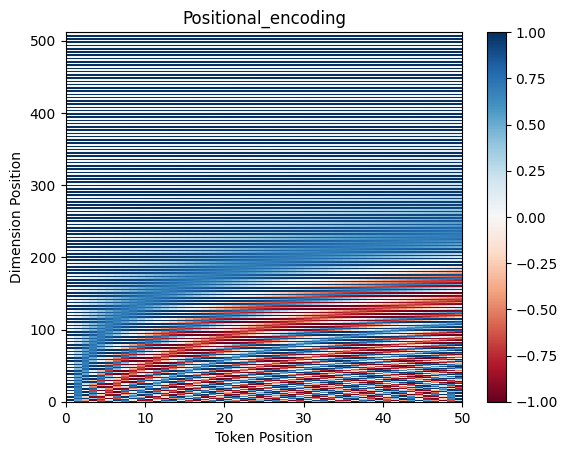

In [ ]:
# Epoch 학습 손실을 그래프로 표시
import matplotlib.pyplot as plt

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)

# Example usage:
example_length = 50 # 예시 길이 설정
example_dim = 512 # 예시 차원 설정

print(positional_encoding(position = example_length, d_model = example_dim).shape) # 위치 인코딩의 shape 출력
plt.pcolormesh(positional_encoding(position = example_length, d_model = example_dim).transpose(-1,-2).numpy()[0,:,:], cmap='RdBu')  # 깊이에 따른 위치 인코딩 시각화
plt.ylabel('Dimension Position') # y축 레이블 설정
plt.xlabel('Token Position') # x축 레이블 설정
plt.title('Positional_encoding') # 제목 설정
plt.colorbar()  # 컬러바 추가
plt.show() # 시각화 결과 출력

In [ ]:
!pip install torchinfo

## [LOG] 모델 정보 출력
 - 샘플 입력 생성: input_size만 제공하는 대신, 이제 torch.randint와 torch.ones를 사용하여 적절한 모양과 데이터 유형을 가진 샘플 input_ids 및 attention_mask 텐서를 만듭니다. 이러한 텐서는 모델의 장치와 일치하도록 'cuda' 장치로 이동됩니다.
 - 두 입력 모두 summary에 전달: input_data 인수를 사용하여 input_ids와 attention_mask를 모두 포함하도록 summary 호출을 수정합니다. 이렇게 하면 torchinfo에서 모델을 분석하는 동안 TextClassifier의 forward 메서드가 필요한 두 인수를 모두 받습니다.

In [ ]:
from torchinfo import summary

# batch_size와 max_len이 이전에 정의되었다고 가정
batch_size = 64  # 실제 배치 크기로 바꾸세요
max_len = 400    # 실제 최대 시퀀스 길이로 바꾸세요

# 샘플 input_ids와 attention_mask 생성
input_ids = torch.randint(0, 30522, (batch_size, max_len), dtype=torch.int64, device='cuda')  # 어휘 크기가 30522라고 가정
attention_mask = torch.ones(batch_size, max_len, dtype=torch.int64, device='cuda')

# 모델 정보 출력, input_ids와 attention_mask 모두 제공
summary(model, input_data=(input_ids, attention_mask), device='cuda')  # 두 입력을 모두 summary에 전달

Layer (type:depth-idx)                                  Output Shape              Param #
TextClassifier                                          [64, 4]                   --
├─DistilBertModel: 1-1                                  [64, 400, 768]            --
│    └─Embeddings: 2-1                                  [64, 400, 768]            --
│    │    └─Embedding: 3-1                              [64, 400, 768]            (23,440,896)
│    │    └─Embedding: 3-2                              [1, 400, 768]             (393,216)
│    │    └─LayerNorm: 3-3                              [64, 400, 768]            (1,536)
│    │    └─Dropout: 3-4                                [64, 400, 768]            --
│    └─Transformer: 2-2                                 [64, 400, 768]            --
│    │    └─ModuleList: 3-5                             --                        (42,527,232)
├─Linear: 1-2                                           [64, 4]                   3,076
Total params: 66,365,956


## [LOG] 학습 손실 그래프
 - 로그 데이터 저장: train_logs와 val_logs 딕셔너리에 학습 및 검증 손실, 정확도, F1 점수를 저장합니다.
 - 정확도 및 F1 점수 계산: 학습 및 검증 데이터 로더를 사용하여 정확도와 F1 점수를 계산하고 로그 딕셔너리에 추가합니다. (이 부분은 실제 데이터와 모델에 맞게 수정해야 합니다.)
 - 그래프 생성: matplotlib.pyplot을 사용하여 학습 손실 vs 검증 손실, 학습 정확도 vs 검증 정확도, 학습 F1 점수 vs 검증 F1 점수 그래프를 생성합니다.
 - 그래프 출력: plt.show()를 사용하여 생성된 그래프를 출력합니다.

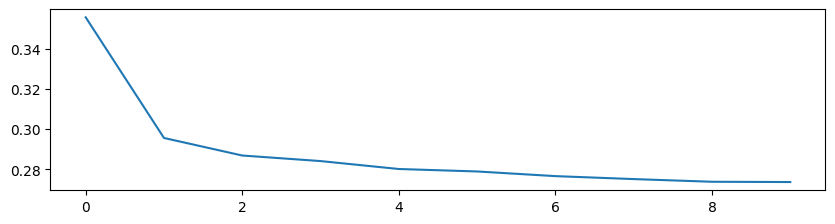

In [ ]:
import matplotlib.pyplot as plt

# 학습 로그 데이터를 담을 딕셔너리 (예시)
train_logs = {
    'loss': train_losses,  # train_losses는 이전 코드에서 계산된 학습 손실 리스트
    'metric': {
        'acc': [],  # 학습 정확도를 저장할 리스트
        'f1': []   # 학습 F1 점수를 저장할 리스트
    }
}
val_logs = {
    'loss': [],  # 검증 손실을 저장할 리스트
    'metric': {
        'acc': [],  # 검증 정확도를 저장할 리스트
        'f1': []   # 검증 F1 점수를 저장할 리스트
    }
}

# 학습 및 검증 데이터 로더를 사용하여 정확도와 F1 점수 계산 (예시)
# 이 부분은 실제 데이터와 모델에 맞게 수정해야 합니다.
# 예를 들어, sklearn.metrics의 accuracy_score, f1_score 등을 사용할 수 있습니다.
# ... (정확도와 F1 점수 계산 코드) ...

# 계산된 정확도와 F1 점수를 로그 딕셔너리에 추가
# ... (train_logs['metric']['acc'], train_logs['metric']['f1'], val_logs['metric']['acc'], val_logs['metric']['f1']에 값 추가) ...

# 그래프 생성
plt.figure(figsize=(10, 8))  # 그래프 크기 설정

# 학습 손실 vs 검증 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 subplot
plt.plot(range(len(train_logs['loss'])), train_logs['loss'], label='train')  # 학습 손실 그래프
plt.plot(range(len(val_logs['loss'])), val_logs['loss'], linestyle='-', marker='o', markersize=5, color='red', label='val')  # 검증 손실 그래

Loss가 잘 떨어지고, 이전에 우리가 구현한 Transformer보다 더 빨리 수렴하는 것을 알 수 있습니다.